In [86]:
class Value:
    """
    Implémente une valeur scalaire qui garde une trace de son historique de calcul.
    Cette classe est le bloc de base pour construire notre réseau de neurones.
    
    Attributs:
        data: La valeur numérique stockée
        grad: Le gradient de cette valeur (utilisé pour la rétropropagation)
        _backward: Fonction qui calcule le gradient local
        _prev: Ensemble des valeurs parentes dans le graphe de calcul
        _op: L'opération qui a créé cette valeur
        label: Étiquette 
    """
    # Initialise une nouvelle instance de la classe Value.
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # Retourne une représentation en chaîne de caractères de l'objet Value.
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Additionne deux objets Value et retourne un nouvel objet Value résultant de l'addition.
    def __add__ (self, other):
        other = other if isinstance(other, Value) else Value(other) # convertit en Value si nécessaire
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    # Additionne deux objets Value et retourne un nouvel objet Value résultant de l'addition.
    def __radd__(self, other): # other + self
        return self + other

    
    # Multiplie deux objets Value et retourne un nouvel objet Value résultant de la multiplication.
    def __mul__ (self, other):
        other = other if isinstance(other, Value) else Value(other) # convertit en Value si nécessaire
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    # Multiplie deux objets Value et retourne un nouvel objet Value résultant de la multiplication.
    def __rmul__ (self, other):
        return self * (other)
    
    # Divise deux objets Value et retourne un nouvel objet Value résultant de la division.
    def __truediv__ (self, other): 
        return self * other**-1
    
    # Expose un objet Value à une puissance et retourne un nouvel objet Value résultant de l'exponentiation.
    def __pow__ (self, other):
        assert isinstance(other, (int, float)), "Ne supporte que les exposants entiers ou flottants"
        out = Value(self.data**other, (self,), f'**{other}')

        def backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = backward
        return out
    
    # Retourne l'opposé d'un objet Value.
    def __neg__(self):
        return -1.0 * self
    
    # Soustrait un objet Value à un autre et retourne un nouvel objet Value résultant de la soustraction.
    def __sub__(self, other):
        return self + (-other)
    
    # Applique la fonction ReLU à un objet Value et retourne un nouvel objet Value résultant de l'application de la fonction.
    # La fonction ReLU retourne 0 si la valeur est négative, et la valeur elle-même sinon.
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    # Retourne l'opposé d'un objet Value.
    def __rsub__(self, other):
        return other + (-self)
    
    # Applique la fonction tangente hyperbolique à un objet Value et retourne un nouvel objet Value résultant de l'application de la fonction.
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    # Applique la fonction exponentielle à un objet Value et retourne un nouvel objet Value résultant de l'application de la fonction.
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    # Effectue une rétropropagation à partir d'un objet Value.
    # La rétropropagation est un algorithme utilisé pour calculer les gradients des paramètres du modèle
    # en fonction de la fonction de perte. Elle permet d'ajuster les poids et les biais du réseau de neurones
    # afin de minimiser l'erreur entre les prédictions et les valeurs cibles.
    def backward(self):
        topo = []
        visited = set()

        # Construit un ordre topologique des nœuds 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        # Pour chaque nœud dans l'ordre topologique, appelle la fonction de rétropropagation
        for node in reversed(topo):
            node._backward()

    """Applique la fonction softmax à la valeur"""
    def softmax(self):
        exp_x = self.exp()
        return exp_x / (1.0 + exp_x)  


In [64]:
from graphviz import Digraph

"""
Construit un ensemble de tous les nœuds et arêtes dans un graphe à partir d'un nœud racine donné."""
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

"""
Génère une visualisation du graphe de calcul sous forme de graphique orienté (format SVG) à partir d'un nœud racine donné.
Permet de visualiser le graphe de calcul et de voir les opérations effectuées sur les valeurs.
"""
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [65]:
# Définit les entrées du neurone
x1 = Value(2.0, label='x1')  # Valeur d'entrée x1
x2 = Value(0.0, label='x2')  # Valeur d'entrée x2

# Initialise les poids associés aux entrées
w1 = Value(-3.0, label='w1')  # Poids pour x1
w2 = Value(1.0, label='w2')   # Poids pour x2

# Initialise le biais du neurone
b = Value(6.8813735870195432, label='b')  # Biais ajouté à la somme pondérée

# Calcul les contributions pondérées des entrées
x1w1 = x1 * w1; x1w1.label = 'x1*w1'  # Contribution de x1
x2w2 = x2 * w2; x2w2.label = 'x2*w2'  # Contribution de x2

# Combine les contributions et ajoute le biais
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'  # Somme des contributions
n = x1w1x2w2 + b; n.label = 'n'  # Somme finale avec le biais

# Applique la fonction d'activation tangente hyperbolique
o = n.tanh(); o.label = 'o'  # Sortie du neurone après activation

# Effectue la rétropropagation pour calculer les gradients
o.backward()  # Calcul des gradients à partir de la sortie

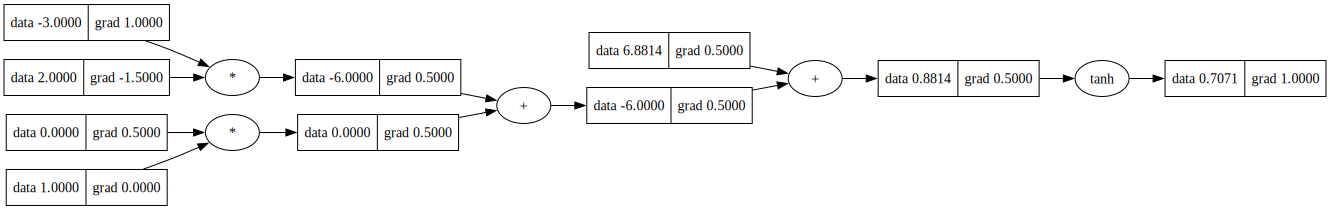

In [66]:
# Affiche le graphe de calcul
draw_dot(o)

In [67]:
import torch

In [68]:
# fais le même calcul en utilisant pytorch pour vérifier (on voit que les gradients sont les mêmes)

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [69]:
import random
class Neuron:
    """
    Représente un neurone artificiel avec des poids et un biais.
    
    Attributs :
        - w : Liste des poids associés aux entrées.
        - b : Biais du neurone, une constante ajoutée à la somme pondérée.
    
    Méthodes :
        - __call__(x) : Calcule la sortie du neurone pour une entrée donnée.
        - parameters() : Retourne tous les paramètres (poids + biais).
    """
    def __init__(self, nin):
        # Initialisation aléatoire des poids et du biais
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # Calcul de la somme pondérée des entrées avec les poids et ajout du biais
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        # Application de la fonction d'activation tangente hyperbolique
        out = act.tanh()
        return out

    def parameters(self):
        # Retourne la liste des paramètres du neurone (poids et biais)
        return self.w + [self.b]



class Layer:
    """
    Représente une couche de neurones.
    Args:
        n_in (int): Nombre d'entrées pour chaque neurone.
        n_out (int): Nombre de neurones dans la couche.
    Méthodes:
        __call__(x): Applique la couche aux entrées x et retourne les sorties.
    """
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        if len(outs)  == 1:
            outs = outs[0]
        return outs
    
    def parameters(self):
        params = []
        for n in self.neurons:
            ps = n.parameters()
            params += ps
        return params

class MLP:
    """
    Perceptron multi-couches (Multi-Layer Perceptron).
    Un réseau de neurones composé de plusieurs couches empilées.
    
    Attributs:
        layers: Liste des couches du réseau
        
    Arguments:
        nin: Nombre d'entrées du réseau
        nouts: Liste définissant le nombre de neurones par couche
    """
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params += ps
        return params

In [70]:
# Création d'un réseau de neurones avec 3 entrées, 1 sortie, et 2 couches intermédiaires avec 4 neurones chacune
x = [2.0, 3.0, -1.0] # valeurs d'entrée
n = MLP(3, [4, 4, 1]) # création du réseau

# affiche la sortie du réseau pour l'entrée x
n(x)


Value(data=-0.5516674715830806)

In [71]:
len(n.parameters()) # affiche le nombre de paramètres du réseau


41

In [72]:
# définit les entrées et les targets pour entraîner le réseau
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # target values

In [73]:

# entraîne le réseau avec 20 itérations en utilisant la descente de gradient
for k in range(20):
    # passe avant   
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # passe arrière
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # mise à jour (descente de gradient pour réduire la perte)
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print('étape: ', k, ' | perte: ', loss.data)

étape:  0  | perte:  6.201784644687452
étape:  1  | perte:  4.597926080386668
étape:  2  | perte:  3.5505217956197113
étape:  3  | perte:  2.880445051591356
étape:  4  | perte:  2.2422491047134607
étape:  5  | perte:  1.6540571983749996
étape:  6  | perte:  1.1857324005944272
étape:  7  | perte:  0.8590892029401339
étape:  8  | perte:  0.643675063907966
étape:  9  | perte:  0.5008815214001744
étape:  10  | perte:  0.40318056607167935
étape:  11  | perte:  0.33377341757852586
étape:  12  | perte:  0.28268818861356326
étape:  13  | perte:  0.24390209786378916
étape:  14  | perte:  0.21366085046426347
étape:  15  | perte:  0.18954257575327077
étape:  16  | perte:  0.16993286697037224
étape:  17  | perte:  0.15372288275343235
étape:  18  | perte:  0.14013033740133488
étape:  19  | perte:  0.12859001002963547


In [74]:
# affiche la sortie du réseau pour les entrées xs (doit se rapprocher des targets ys)
ypred

[Value(data=0.8549078779922769),
 Value(data=-0.7719518312377236),
 Value(data=-0.8623776191473682),
 Value(data=0.8087086014125128)]

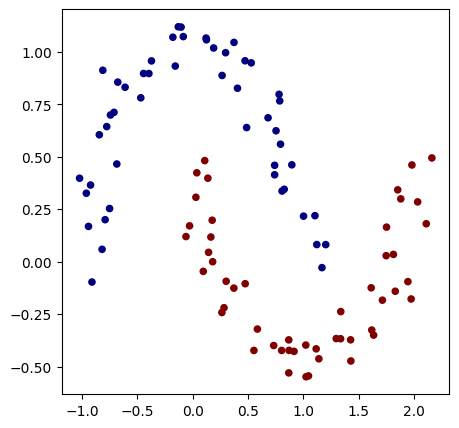

In [95]:
# Cette fois nous allons tester le réseau sur un problème de classification 

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1337)
random.seed(1337)

# Génération des données (des points dans un plan)

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1) 
y = y*2 - 1 
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [96]:
# Initialisation du réseau de neurones (2 couches intermédiaires avec 16 neurones chacune, et 1 neurone en sortie)
model = MLP(2, [16, 16, 1]) 
print("nb paramètres: ", len(model.parameters()))

number of parameters 337


In [97]:
# Fonction de perte 
# calcul la perte et la précision du modèle
def loss(batch_size=None):
    
    # Chargement des données en ligne
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    # Convertit les entrées en objets Value
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Applique le modèle pour obtenir les scores
    scores = list(map(model, inputs))
    
    # Calcul de la perte avec relu
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # Régularisation L2 (évite le surapprentissage)
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # Calcul de la précision
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.7840043023159258) 0.68


In [98]:
# optimisation
for k in range(100):
    
    # passe avant
    total_loss, acc = loss()
    
    # passe arrière
    for p in model.parameters():
        p.grad = 0.0
    total_loss.backward()
    
    # mise à jour (descente de gradient)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.7840043023159258, accuracy 68.0%
step 1 loss 0.5346887893624206, accuracy 73.0%
step 2 loss 0.40486112398826374, accuracy 83.0%
step 3 loss 0.3380828095624803, accuracy 86.0%
step 4 loss 0.2942618979033041, accuracy 88.0%
step 5 loss 0.2713707188453524, accuracy 90.0%
step 6 loss 0.2557758037037018, accuracy 90.0%
step 7 loss 0.24353269446140005, accuracy 91.0%
step 8 loss 0.23311666335881745, accuracy 91.0%
step 9 loss 0.22371429713875024, accuracy 91.0%
step 10 loss 0.21478840620418216, accuracy 91.0%
step 11 loss 0.20603142190103865, accuracy 91.0%
step 12 loss 0.1972226427758724, accuracy 92.0%
step 13 loss 0.18824544635214918, accuracy 93.0%
step 14 loss 0.17902966856680744, accuracy 94.0%
step 15 loss 0.16967500545392217, accuracy 94.0%
step 16 loss 0.16033439848659775, accuracy 94.0%
step 17 loss 0.15200986278726358, accuracy 96.0%
step 18 loss 0.14550876426551498, accuracy 96.0%
step 19 loss 0.15276142639895654, accuracy 95.0%
step 20 loss 0.14406510423987692, acc

(-1.548639298268643, 1.951360701731357)

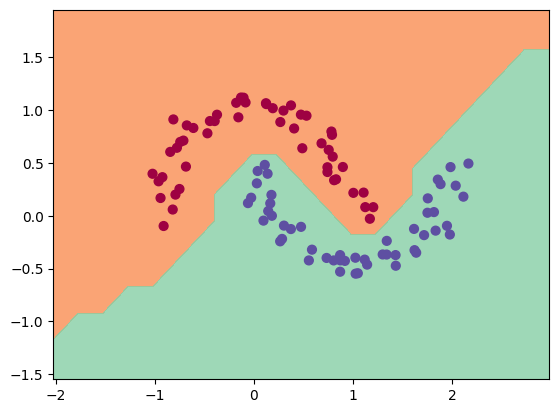

In [99]:
# visualisation de la frontière de décision 
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())